<a href="https://colab.research.google.com/github/shown5/HandsOnLLM/blob/main/chap9_multimodal_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install matplotlib transformers datasets accelerate sentence-transformers

In [2]:
from urllib.request import urlopen
from PIL import Image

# 雪の中で遊ぶ子犬のAI生成画像を読み込む
puppy_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
image = Image.open(urlopen(puppy_path)).convert("RGB")

caption = "a puppy playing in the snow"

In [3]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

# テキストを前処理するためのトークナイザーを読み込む
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

# 画像を前処理するためのプリプロセッサーを読み込む
clip_processor = CLIPProcessor.from_pretrained(model_id)

# テキストと画像の埋め込みを生成するためのメインモデルを読み込む
model = CLIPModel.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [4]:
# テキストをトークン化する
inputs = clip_tokenizer(caption, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [5]:
# トークンIDをテキストに変換する
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [6]:
# テキスト埋め込みを生成する
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [7]:
# 画像を前処理する
processed_image = clip_processor(
    text=None, images=image, return_tensors="pt"
)["pixel_values"]

processed_image.shape

torch.Size([1, 3, 224, 224])

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

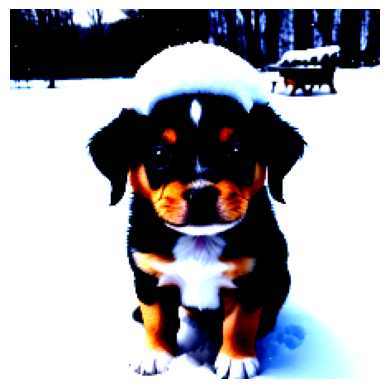

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 画像を可視化するための準備
img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1))
img = np.einsum("ijk->jik", img)

# 前処理された画像を可視化する
plt.imshow(img)
plt.axis("off")

In [9]:
# 画像埋め込みを生成する
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [10]:
# 埋め込みを正規化する
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

# 類似度を計算する
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()
score = np.dot(text_embedding, image_embedding.T)
score

array([[0.33149645]], dtype=float32)

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# プロセッサーとメインモデルを読み込む
blip_processor = AutoProcessor.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24"  # Choose specific model because of: https://huggingface.co/Salesforce/blip2-opt-2.7b/discussions/39
)
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24",
    torch_dtype=torch.float16
)

# 推論を高速化するためにモデルをGPUに送る
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

In [ ]:
# スーパーカーの画像を読み込む
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
image = Image.open(urlopen(car_path)).convert("RGB")

image

In [ ]:
# 画像を前処理する
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
inputs["pixel_values"].shape